In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jaxtyping import Float, Array
from typing import Any

from flowMC.resource.local_kernel.MALA import MALA
from flowMC.resource.buffers import Buffer
from flowMC.strategy.take_steps import TakeSerialSteps
from flowMC.strategy.parallel_tempering import ParallelTempering
from flowMC.Sampler import Sampler
from flowMC.resource.logPDF import TemperedPDF, LogPDF


def target_dual_moon(x: Float[Array, "n_dims"], data: dict[str, Any]) -> Float:
    """
    Term 2 and 3 separate the distribution and smear it along the first and second dimension
    """
    term1 = 0.5 * ((jnp.linalg.norm(x) - 2) / 0.1) ** 2
    term2 = -0.5 * ((x[:1] + jnp.array([-3.0, 3.0])) / 0.8) ** 2
    term3 = -0.5 * ((x[1:2] + jnp.array([-3.0, 3.0])) / 0.6) ** 2
    return -(term1 - logsumexp(term2) - logsumexp(term3))

In [2]:
# Defining hyperparameters
n_chains = 5
rng_key = jax.random.PRNGKey(0)
n_steps = 200
step_size = 0.1
n_dims = 5
data = {"data": jnp.arange(n_dims).astype(jnp.float32)}
# Setting up resources

MALA_sampler = MALA(step_size=step_size)
positions = Buffer("positions", (n_chains, n_steps, n_dims), 1)
log_prob = Buffer("log_prob", (n_chains, n_steps), 1)
acceptance = Buffer("acceptance", (n_chains, n_steps), 1)
resource = {
    "positions": positions,
    "log_prob": log_prob,
    "acceptance": acceptance,
    "MALA": MALA_sampler,
    "logpdf": LogPDF(target_dual_moon, n_dims=n_dims),
    # "logpdf": TemperedPDF(target_dual_moon, lambda x, data: jnp.array(0.0), n_dims=n_dims, n_temps=5),
}

# Defining strategy

strategy = TakeSerialSteps(
    logpdf_name="logpdf",
    kernel_name="MALA",
    buffer_names=["positions", "log_prob", "acceptance"],
    n_steps=n_steps,
)

# Initializing sampler

sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resources=resource,
    strategies={"take_steps": strategy},
    strategy_order=["take_steps"],
)

sampler.sample(
    initial_position=jax.random.normal(rng_key, (n_chains, n_dims)),
    data=data,
)

Resources and strategies provided. Ignoring resource strategy bundles.
Compiling MALA body


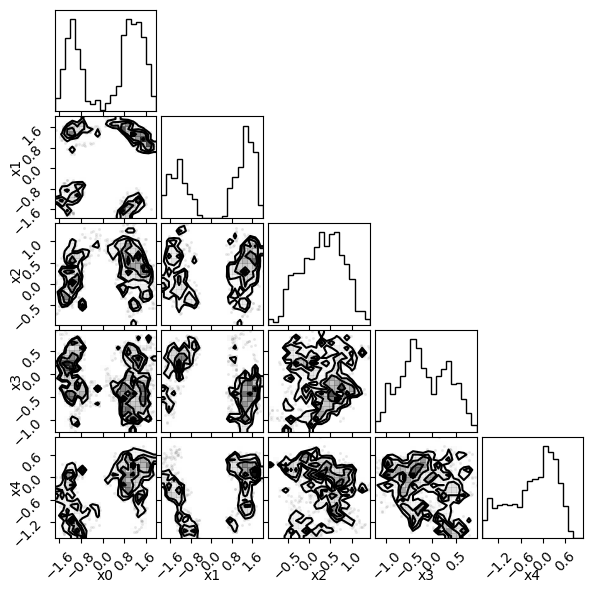

In [3]:
import corner
import numpy as np
import matplotlib.pyplot as plt

chains = sampler.resources["positions"].data

labels = [f"x{i}" for i in range(n_dims)]

# Plotting chain from flowMC
fig = plt.figure(figsize=(6, 6))
fig = corner.corner(np.array(chains.reshape(-1, n_dims)), fig=fig, labels=labels)

In [4]:
import itertools

# Defining hyperparameters
n_chains = 5
n_steps = 40
step_size = 0.1
n_dims = 5
n_temps = 5
n_loops = 5
data = {
    "data": jnp.arange(n_dims).astype(jnp.float32),
}
# Setting up resources

logpdf = LogPDF(target_dual_moon, n_dims=n_dims)

tempered_logpdf = TemperedPDF(
    target_dual_moon,
    lambda x, data: jnp.array(0.0),
    n_dims=n_dims,
    n_temps=n_temps,
)

key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
initial_position = jax.random.normal(subkey, shape=(n_chains, n_dims))
key, subkey = jax.random.split(key)
tempered_initial_position = jax.random.normal(
    subkey, shape=(n_chains, n_temps - 1, n_dims)
)
tempered_positions = Buffer("tempered_positions", (n_chains, n_temps - 1, n_dims), 2)
tempered_positions.update_buffer(tempered_initial_position)

MALA_sampler = MALA(step_size=step_size)
positions = Buffer("positions", (n_chains, n_steps * n_loops, n_dims), 1)
log_prob = Buffer("log_prob", (n_chains, n_steps * n_loops), 1)
acceptance = Buffer("acceptance", (n_chains, n_steps * n_loops), 1)
positions.update_buffer(initial_position[:, None])
log_prob.update_buffer(
    jax.vmap(logpdf, in_axes=(0, None))(initial_position, data)[:, None]
)

temperatures = Buffer("temperature", (n_temps,), 0)
temperatures.update_buffer(jnp.arange(n_temps) * 3 + 1.0)

resources = {
    "logpdf": logpdf,
    "tempered_logpdf": tempered_logpdf,
    "MALA": MALA_sampler,
    "positions": positions,
    "log_prob": log_prob,
    "acceptance": acceptance,
    "tempered_positions": tempered_positions,
    "temperatures": temperatures,
}


take_steps = TakeSerialSteps(
    logpdf_name="logpdf",
    kernel_name="MALA",
    buffer_names=["positions", "log_prob", "acceptance"],
    n_steps=n_steps,
)

parallel_tempering_strat = ParallelTempering(
    n_steps=n_steps,
    tempered_logpdf_name="tempered_logpdf",
    kernel_name="MALA",
    tempered_buffer_names=["tempered_positions", "temperatures"],
    data_keys=["data"],
)

strategy_order = [["take_steps", "parallel_tempering"] for _ in range(n_loops)]
strategy_order = list(itertools.chain.from_iterable(strategy_order))

sampler = Sampler(
    n_dim=n_dims,
    n_chains=n_chains,
    rng_key=rng_key,
    resources=resources,
    strategies={
        "take_steps": take_steps,
        "parallel_tempering": parallel_tempering_strat,
    },
    strategy_order=strategy_order,
)

sampler.sample(
    initial_position=initial_position,
    data=data,
)

Resources and strategies provided. Ignoring resource strategy bundles.
Compiling MALA body
Compiling MALA body
Temperatures: [ 1.  4.  7. 10. 13.]
Temperatures: [ 1.         3.4561923  7.        10.        13.       ]
Temperatures: [ 1.        4.        5.646435  8.035722 13.      ]
Temperatures: [ 1.         4.6642084  5.3226147  7.141265  13.       ]
Temperatures: [ 1.        4.        5.615445  7.479086 13.      ]


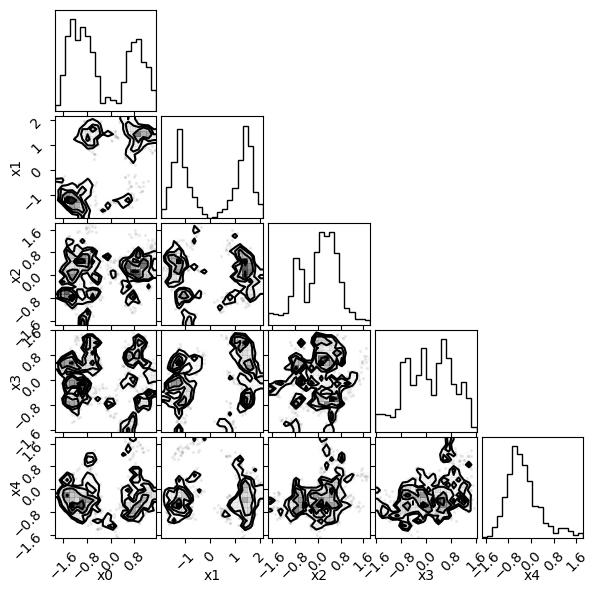

In [5]:
chains = sampler.resources["positions"].data

labels = [f"x{i}" for i in range(n_dims)]

# Plotting chain from flowMC
fig = plt.figure(figsize=(6, 6))
fig = corner.corner(np.array(chains.reshape(-1, n_dims)), fig=fig, labels=labels)

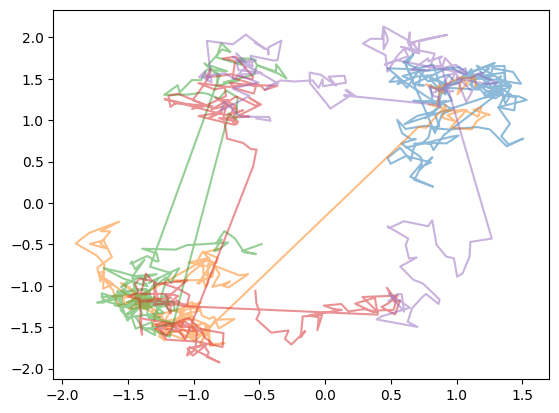

In [6]:
plt.plot(chains[:, :, 0].T, chains[:, :, 1].T, alpha=0.5)

In [7]:
sampler.resources["temperatures"].data

Array([ 1.      ,  4.      ,  5.615445,  7.479086, 13.      ], dtype=float32)